In [1]:
# %load_ext tensorboard

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from timeit import default_timer

from genotype.genotype import RandomArchitectureGenerator

In [2]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]




In [3]:
# helper functions

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(npimg.shape)
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels, classes):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    fig.tight_layout()
    return fig

In [4]:
batch_size = 8
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST('mnist_train', train=True, download=True, transform=transform)
testset = datasets.MNIST('mnist_test', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

# Setup
Setup the RAG model and send info to tensorboard

Final depth:4
Number of nodes:7


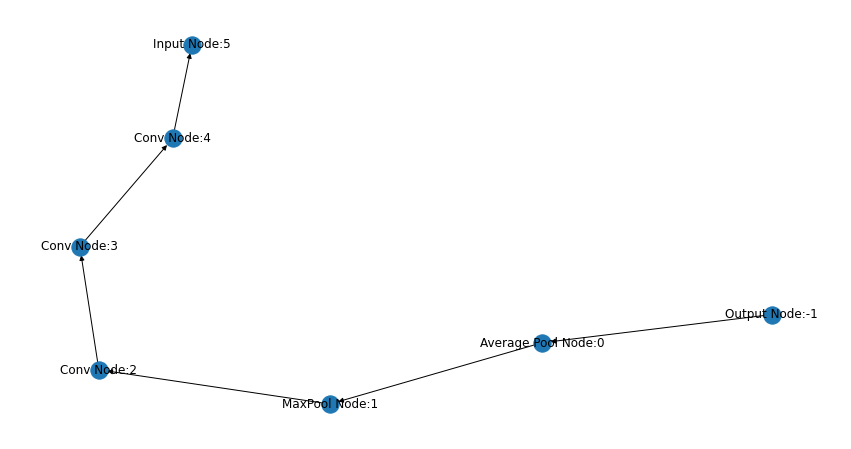

In [5]:
images, labels = next(iter(trainloader))
rag = RandomArchitectureGenerator(
    prediction_classes=10,
    min_depth=5,
    max_depth=7,
    image_size=int(images.shape[2]),
    input_channels=int(images.shape[1]),
    min_nodes=5
)

rag.get_architecture()
cont = rag.controller()
rag.show()

In [6]:
cont.cuda()

Controller(
  (module_dict): ModuleDict(
    (5:Input_Node): Identity()
    (4:Conv_Node): Sequential(
      (0): Conv2d(1, 512, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3:Conv_Node): Sequential(
      (0): Conv2d(512, 512, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2:Conv_Node): Sequential(
      (0): Conv2d(512, 512, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1:MaxPool_Node): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (0:Average

In [7]:
writer = SummaryWriter()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


images, labels = next(iter(trainloader))
if torch.cuda.is_available():
     images= images.to(device).cuda(device)
# cont.update_device(device)
# cont.to(device)

grid = torchvision.utils.make_grid(images).to(device).cuda()


writer.add_image('images', grid, 0)
writer.add_graph(cont, images)
del images

running_loss = 0.0

lr = 0.8
# optimizer = optim.Adam(cont.parameters(), lr=lr,)   
optimizer = optim.Adam(cont.module_dict.parameters(), lr=lr,)  
criterion = nn.CrossEntropyLoss()


# can add milestones in later if needed
# milestones = [k for k in range(0, num_epochs*len(trainloader), 50)]

# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.95)

AttributeError: 'dict' object has no attribute 'dim'

In [8]:
batch_tt = np.empty(shape=(10,))
k=0
num_epochs = 2
start_t = default_timer()
for epoch in range(num_epochs-1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):
        batch_st = default_timer() 
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = [d.to(device).cuda(device) for d in data]
        inputs.requires_grad = True

        # zero the parameter gradients
        optimizer.zero_grad()

#         # forward + backward + optimize
        outputs = cont(inputs)
        loss = criterion(outputs, labels).to(device)
        loss.backward()
        optimizer.step()

#         with torch.no_grad():
#             for p in cont.parameters():
                
#                 p.sub_(lr* p.grad)
#             print(torch.all(p.grad.eq(0)))
#             p = []
        
#         scheduler.step()

        running_loss += loss.item()
        
        batch_et = default_timer()
        
        batch_tt[k] = batch_et - batch_st
        
        k+=1
        
        if i % 10 == 9:    # every 10 batches...
            
            
            # ...log the running loss
            writer.add_scalar('Training loss',
                            running_loss / 10,
                            epoch * len(trainloader) + i)
            writer.add_scalar('Learning rate',+
                            optimizer.param_groups[0]['lr'],
                            epoch * len(trainloader) + i)
            writer.add_scalar('Average batch time',
                            np.mean(batch_tt).item(),
                            epoch * len(trainloader) + i)
            
            running_loss = 0.0
            batch_tt = np.empty(shape=(10,))
            k=0
            
#         if i > 50:
#             break
        


end_t = default_timer()

total_t = end_t - start_t

writer.add_scalar('Total training time',
                   total_t,
                epoch * len(trainloader) + i)

        

KeyboardInterrupt: 

In [61]:
list(cont.module_dict.parameters())

[Parameter containing:
 tensor([[[[-1.5990e-01, -9.7942e-02,  5.0226e-03,  ...,  1.9742e-01,
             1.4729e-01,  1.0208e-01],
           [-7.6299e-02, -6.8681e-02, -4.5328e-02,  ...,  2.4870e-02,
            -2.7810e-02,  7.8350e-02],
           [-5.1901e-02, -6.1059e-02, -1.5014e-02,  ...,  1.1504e-01,
             1.2390e-01,  2.0242e-01],
           ...,
           [ 1.5141e-01,  4.3206e-02, -7.1445e-02,  ...,  1.0480e-01,
            -9.0759e-06,  6.1600e-02],
           [ 1.0759e-01, -6.3953e-02,  1.6421e-01,  ...,  1.7835e-01,
            -7.7521e-02,  8.9601e-02],
           [ 1.7176e-01,  5.1343e-02, -1.3152e-02,  ..., -4.2158e-03,
             4.9071e-02, -4.8466e-02]]],
 
 
         [[[ 6.1937e-02,  1.8164e-01,  1.8973e-01,  ..., -5.8223e-03,
             3.5658e-02,  9.4269e-02],
           [-1.7112e-01,  9.7162e-02, -3.1565e-03,  ..., -7.0301e-02,
             1.8508e-01,  8.9966e-02],
           [-1.6398e-01,  5.3017e-02,  7.3726e-02,  ..., -9.5444e-02,
            -

In [50]:
optimizer = optim.Adam(cont.module_dict.parameters(), lr=lr,)   

In [82]:
cont.backward()

ModuleAttributeError: 'Controller' object has no attribute 'backward'

In [59]:
optimizer.param_groups[0]

{'params': [Parameter containing:
  tensor([[[[-1.5990e-01, -9.7942e-02,  5.0226e-03,  ...,  1.9742e-01,
              1.4729e-01,  1.0208e-01],
            [-7.6299e-02, -6.8681e-02, -4.5328e-02,  ...,  2.4870e-02,
             -2.7810e-02,  7.8350e-02],
            [-5.1901e-02, -6.1059e-02, -1.5014e-02,  ...,  1.1504e-01,
              1.2390e-01,  2.0242e-01],
            ...,
            [ 1.5141e-01,  4.3206e-02, -7.1445e-02,  ...,  1.0480e-01,
             -9.0759e-06,  6.1600e-02],
            [ 1.0759e-01, -6.3953e-02,  1.6421e-01,  ...,  1.7835e-01,
             -7.7521e-02,  8.9601e-02],
            [ 1.7176e-01,  5.1343e-02, -1.3152e-02,  ..., -4.2158e-03,
              4.9071e-02, -4.8466e-02]]],
  
  
          [[[ 6.1937e-02,  1.8164e-01,  1.8973e-01,  ..., -5.8223e-03,
              3.5658e-02,  9.4269e-02],
            [-1.7112e-01,  9.7162e-02, -3.1565e-03,  ..., -7.0301e-02,
              1.8508e-01,  8.9966e-02],
            [-1.6398e-01,  5.3017e-02,  7.3726e-02,  

In [56]:
optimizer.param_groups[0]

{'params': [Parameter containing:
  tensor([[[[-1.5990e-01, -9.7942e-02,  5.0226e-03,  ...,  1.9742e-01,
              1.4729e-01,  1.0208e-01],
            [-7.6299e-02, -6.8681e-02, -4.5328e-02,  ...,  2.4870e-02,
             -2.7810e-02,  7.8350e-02],
            [-5.1901e-02, -6.1059e-02, -1.5014e-02,  ...,  1.1504e-01,
              1.2390e-01,  2.0242e-01],
            ...,
            [ 1.5141e-01,  4.3206e-02, -7.1445e-02,  ...,  1.0480e-01,
             -9.0759e-06,  6.1600e-02],
            [ 1.0759e-01, -6.3953e-02,  1.6421e-01,  ...,  1.7835e-01,
             -7.7521e-02,  8.9601e-02],
            [ 1.7176e-01,  5.1343e-02, -1.3152e-02,  ..., -4.2158e-03,
              4.9071e-02, -4.8466e-02]]],
  
  
          [[[ 6.1937e-02,  1.8164e-01,  1.8973e-01,  ..., -5.8223e-03,
              3.5658e-02,  9.4269e-02],
            [-1.7112e-01,  9.7162e-02, -3.1565e-03,  ..., -7.0301e-02,
              1.8508e-01,  8.9966e-02],
            [-1.6398e-01,  5.3017e-02,  7.3726e-02,  

In [14]:
from sys import getsizeof
local_vars = list(locals().items())
for var, obj in local_vars:
    print(var, getsizeof(obj))

__name__ 57
__doc__ 113
__package__ 16
__loader__ 16
__spec__ 16
__builtin__ 72
__builtins__ 72
_ih 192
_oh 232
_dh 64
In 192
Out 232
get_ipython 64
exit 48
quit 48
_ 51
__ 51
___ 51
_i 147
_ii 64
_iii 74
_i1 421
torch 72
nn 72
F 72
optim 72
SummaryWriter 1192
torchvision 72
datasets 72
transforms 72
matplotlib 72
plt 72
np 72
default_timer 72
RandomArchitectureGenerator 2008
_i2 320
select_n_random 136
_i3 1770
matplotlib_imshow 136
images_to_probs 136
plot_classes_preds 136
_i4 512
batch_size 28
transform 48
trainset 48
testset 48
trainloader 48
testloader 48
_i5 341
images 64
labels 64
rag 48
_i6 729
writer 48
device 24
_i7 1975
batch_tt 176
k 24
num_epochs 28
start_t 24
epoch 24
i 24
data 88
batch_st 24
inputs 64
_i8 1985
_i9 1996
_i10 57
_i11 74
getsizeof 72
_i12 64
_i13 147
local_vars 632
var 57
obj 57
_i14 143


In [78]:
opt = optim.Adam(cont.parameters(), lr=lr,)   
opt.zero_grad()
outputs = cont(inputs)
loss = criterion(outputs, labels).to(device)
loss.backward()
opt.step()
opt

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.8
    weight_decay: 0
)

In [21]:
cont.network_map['1:Conv_Node'].model.model[2].weight.is_leaf

True

In [60]:
for k,v in cont.module_dict.parameters():
    print(v.weights.grad)

ValueError: too many values to unpack (expected 2)

In [55]:
list(cont.module_dict['4:Conv_Node'].modules())[2].weight.grad

KeyError: '4:Conv_Node'